In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from matplotlib import rc 

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')

models = ['mbert', 'bertimbau', 'distilbertimbau', 'ptt5']

In [2]:
def clean_text(text):
    # Handle common misinterpretations from double encoding
    replacements = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã\xad': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã£': 'ã', 'Ãµ': 'õ', 'Ã¢': 'â', 'Ãª': 'ê', 'Ã´': 'ô',
        'Ã§': 'ç', 'Ã ': 'à', 'Ãš': 'Ú', 'Ã\x81': 'Á', 'Ã‰': 'É',
        'Ã\x8d': 'Í', 'Ã“': 'Ó', 'Ãš': 'Ú', 'Ã“': 'Ó'
    }
    for wrong, right in replacements.items():
        text = text.replace(wrong, right)
    return text

def read_files(file, model, method):
    with open(file, 'r', encoding="latin1") as f:
        lines = f.readlines()
        for l in lines:
            if l.strip():  # This checks that the line is not empty or just a newline
                # Decode and correct the encoding issues before evaluation
                corrected_line = l.encode('latin1').decode('utf-8', errors='replace')
                corrected_line = clean_text(corrected_line)
                
                # Use eval to convert string to list of tuples
                data = list(eval(corrected_line))
                
                data.sort(key=lambda tup: tup[1], reverse=True)
                pred[model][method].append(data)

In [5]:
pred = {}

for model in ['bertimbau', 'distilbertimbau', 'ptt5', 'mbert']:
    pred[model] = {}
    for method in ['lime', 'shap']:
        pred[model][method] = []
        paths = []
        for name in glob.glob('../results/'+model+'_'+method+'*'):
            paths.append(name)

        for filename in sorted(paths):    
            read_files(filename, model, method)

In [12]:
to_remove = []

In [233]:
def get_importance_vector(model, method, balanced=False):
    aux = {}
    
    if model == 'all':
        for c in [0, 1]:
            for m in models:
                for lines in pred[m][method]:
                    for word, score in lines:
                        try:
                            aux[word.replace(' ', '')].append(score)
                        except:
                            aux[word.replace(' ', '')] = []
                            aux[word.replace(' ', '')].append(score)
    else:
        for c in [0, 1]:
            for lines in pred[model][method]:
                for word, score in lines:
                    try:
                        aux[word.replace(' ', '')].append(score)
                    except:
                        aux[word.replace(' ', '')] = []
                        aux[word.replace(' ', '')].append(score)

    word_mean_importance = {}
    for word in aux:
        word_mean_importance[word] = np.mean(aux[word])

    if balanced:
        importance = {k: v for k, v in sorted(word_mean_importance.items(), key=lambda item: np.abs(item[1]), reverse=True)}
        new_dict = {}
        count_neg = 0
        count_pos = 0
        for i in importance:
            if i in to_remove:
                continue
            if importance[i] > 0 and count_pos < 10:
                count_pos += 1
                new_dict[i] = importance[i]
            elif importance[i] < 0 and count_neg < 10:
                count_neg += 1
                new_dict[i] = importance[i]
            if count_pos == 10 and count_neg == 10:
                return new_dict

    return {k: v for k, v in sorted(word_mean_importance.items(), key=lambda item: np.abs(item[1]), reverse=True)[:50]}

In [237]:
df_importance = pd.DataFrame()
labels = []
for m in models:
    for e in ['lime', 'shap']:
        labels.append(m+'\_'+e)
        importance = get_importance_vector(m, e, False)
        df_importance = pd.concat([df_importance, pd.DataFrame([importance])])
df_importance

,marionete,asco,internato,coitadinha,doentes,praga,presídio,incompetente,safado,traidores,...,débil,pretalhões,hipócrita,babacas,vagabundo,ambulante,lixo,pirralha,ridícula,bosta
0,0.952369,0.948300,0.947308,0.945701,0.945383,0.939471,0.939442,0.936121,0.934221,0.933279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.999915,0.999925,0.999888,0.999934,NaN,0.998509,NaN,0.884859,NaN,0.999935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.946196,0.757011,0.905707,NaN,0.916760,NaN,0.907291,0.712516,NaN,0.777764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.957074,0.907046,0.919346,NaN,NaN,NaN,0.881873,0.804735,NaN,0.836506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.997226,0.632562,0.996627,0.985000,NaN,NaN,0.995777,0.810556,NaN,0.859847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.978225,NaN,0.982671,0.971426,NaN,NaN,0.835094,0.738430,NaN,0.947000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.706187,0.863081,0.696785,0.747831,NaN,0.791449,0.716863,NaN,NaN,0.617588,...,0.53692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.880839,0.886017,0.617988,0.812880,NaN,0.605805,NaN,0.842354,NaN,NaN,...,NaN,0.81447,0.710468,0.658959,0.632431,0.632278,0.624752,0.610455,0.603213,0.586155


In [238]:
labels = ['mBERT [LIME]', 'mBERT [SHAP]', 'BERTimbau [LIME]', 'BERTimbau [SHAP]', 'DistilBERTimbau [LIME]', 'DistilBERTimbau [SHAP]', 'PTT5 [LIME]', 'PTT5 [SHAP]']

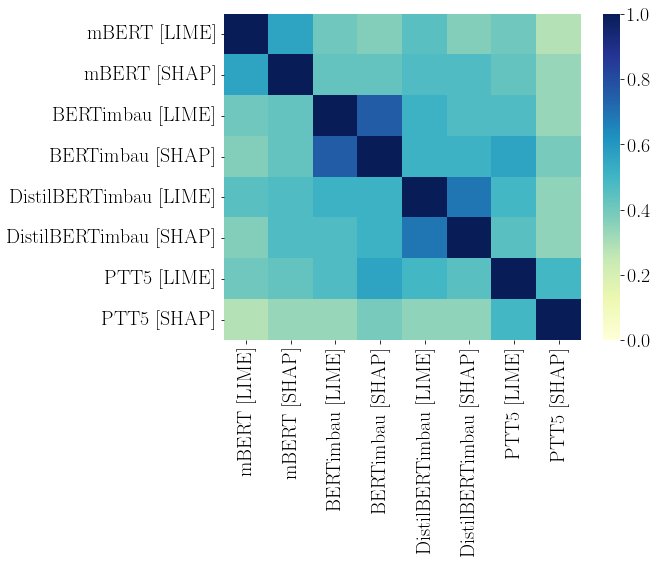

,mBERT [LIME],mBERT [SHAP],BERTimbau [LIME],BERTimbau [SHAP],DistilBERTimbau [LIME],DistilBERTimbau [SHAP],PTT5 [LIME],PTT5 [SHAP]
0,1.000000,0.562500,0.408451,0.369863,0.449275,0.369863,0.408451,0.282051
1,0.562500,1.000000,0.428571,0.428571,0.470588,0.470588,0.428571,0.333333
2,0.408451,0.428571,1.000000,0.754386,0.515152,0.470588,0.470588,0.333333
3,0.369863,0.428571,0.754386,1.000000,0.515152,0.515152,0.562500,0.388889
4,0.449275,0.470588,0.515152,0.515152,1.000000,0.694915,0.492537,0.351351
5,0.369863,0.470588,0.470588,0.515152,0.694915,1.000000,0.449275,0.351351
6,0.408451,0.428571,0.470588,0.562500,0.492537,0.449275,1.000000,0.492537
7,0.282051,0.333333,0.333333,0.388889,0.351351,0.351351,0.492537,1.000000


In [243]:
from copy import copy
import seaborn as sns 

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def get_jaccard_plot(df_importance, labels, f_name=None):
    df_importance = df_importance.fillna(-1)
    
    zero_data = np.zeros(shape=(len(df_importance), len(df_importance)))
    cols = labels
    d = pd.DataFrame(zero_data, columns=cols)

    data = []
    for i in range(len(df_importance)):
        aux = []
        for j in df_importance.columns:
            if df_importance[j].iloc[i] != -1:
                aux.append(j)
        data.append(aux)
        
    count = 0
    for i in range(len(d)):
        for k,j in enumerate(d.columns):
            d[j][i] = jaccard(data[i], data[k])
            
    
    my_cmap = copy(plt.cm.YlGnBu)
    my_cmap.set_over("white")
    my_cmap.set_under("white")
    
    fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
    g = sns.heatmap(d, vmin=0, fmt=".2f",ax=ax, cmap=my_cmap)
    l=list(np.arange(1,6+1))
    g.xaxis.get_label().set_fontsize(16)
    g.yaxis.get_label().set_fontsize(16)
    g.set_xticklabels(labels,rotation=90, fontsize=20)
    g.set_yticklabels(labels, rotation=0, fontsize=20)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()
    
    return d

get_jaccard_plot(df_importance, labels, 'jaccard.jpg')

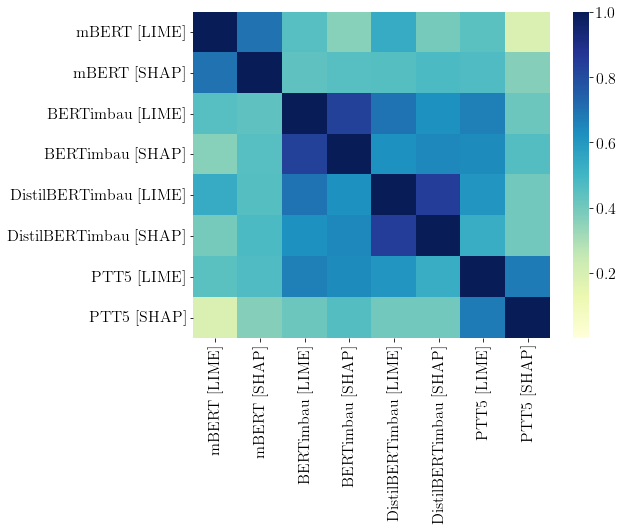

,mBERT [LIME],mBERT [SHAP],BERTimbau [LIME],BERTimbau [SHAP],DistilBERTimbau [LIME],DistilBERTimbau [SHAP],PTT5 [LIME],PTT5 [SHAP]
0,1.000000,0.700189,0.457386,0.362235,0.538132,0.392035,0.449664,0.191910
1,0.700189,1.000000,0.441246,0.455439,0.460034,0.477886,0.471924,0.366611
2,0.457386,0.441246,1.000000,0.832748,0.695727,0.622278,0.667407,0.413423
3,0.362235,0.455439,0.832748,1.000000,0.622161,0.648304,0.637735,0.464872
4,0.538132,0.460034,0.695727,0.622161,1.000000,0.844928,0.607078,0.402201
5,0.392035,0.477886,0.622278,0.648304,0.844928,1.000000,0.531579,0.400754
6,0.449664,0.471924,0.667407,0.637735,0.607078,0.531579,1.000000,0.679192
7,0.191910,0.366611,0.413423,0.464872,0.402201,0.400754,0.679192,1.000000


In [231]:
from scipy import stats

def get_spearmans_plot(df_importance, labels, f_name=None):
    df_importance = df_importance.fillna(0)
    
    zero_data = np.zeros(shape=(len(df_importance), len(df_importance)))
    cols = labels
    d = pd.DataFrame(zero_data, columns=cols)

    data = []
    for i in range(len(df_importance)):
        data.append(df_importance.iloc[i])

    count = 0
    for i in range(len(d)):
        for k,j in enumerate(d.columns):
            d[j][i] = stats.spearmanr(data[i], data[k])[0]
            if stats.spearmanr(data[i], data[k])[1] > 0.05:
                d[j][i] = -1
            
    
    my_cmap = copy(plt.cm.YlGnBu)
    my_cmap.set_over("white")
    my_cmap.set_under("white")
    
    fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
    g = sns.heatmap(d, vmin=0.001, fmt=".2f",ax=ax, cmap=my_cmap)
    l=list(np.arange(1,6+1))
    g.xaxis.get_label().set_fontsize(16)
    g.yaxis.get_label().set_fontsize(16)
    g.set_xticklabels(labels,rotation=90, fontsize=16)
    g.set_yticklabels(labels, rotation=0, fontsize=16)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()
    
    return d

get_spearmans_plot(df_importance, labels, 'spearmans.jpg')